# Send rate and latency versus Link Load parameter

This example experiment shows how to:

* how to run POOSL models with replaced system parameters
* collect the send rate and latency data from the POOSL simulations
* plot the trend of send rate and latency versus Link Load

In [37]:
# import the convenience utility to run parameterized POOSL models
import run_network_model

# Set up experiment
The experiment needs to know certain parameters: such as the number of nodes, what values it should use for the default model parameters, as well as the experiment values (in this case the link load).

In [38]:
# set up the environment
import os, numpy

In [39]:
nrNodes = 4
# initialize template parameters
default_params = {'Load' : 0.95, 
                  'NIBufferCapacity' : 2,
                  'SoC_type' : 'Mesh_2x2',
                  'NumberOfXNodes' : 2,
                  'NumberOfYNodes' : 2
                 }

output_directory_template = 'Mesh_2x2/load_{0}'

# put the absolute path to your model here; do not forget to change \ to / in the path on Windows
model_path = 'C:/path/to/eclipse_project/'

# define the ranges for the experiments
load_values = numpy.linspace(0.05, 0.95, 10) # 10 evenly spaced values between 0.05 and 0.95
## note that the output from linspace may show 0.50, but instead the real value is 0.4999994
## Therefore the literal 0.50 cannot be used to look up the data! Use load_values[2] or similar 
## to look up the values instead.

## Run the parameterized models
Now we execute one model for every `Load` value in our experiment. The `load_value` variable ranges from 0.05 to 0.95 in 4 steps. 

The log files are stored in separate output directories, as the output directory depends on the load parameter. 

In [40]:
for load_value in load_values:

    print("Running experiment for load = {0}".format(load_value))

    # determine where to place the output files (Sendrate and Latency.log); this is relative to the Jupyter script
    output_directory = os.path.abspath(output_directory_template.format(load_value))

    model_parameters = default_params
    # set model parameters that are specific to this particular experiment run 
    # (combines default parameter settings if they exist)
    model_parameters.update(
        {
            'Load': load_value
        }
    )

    if run_network_model.run_network_model(
            [model_path], # library paths
            open('mesh_template.poosl').read(), # system instance template
        nrNodes, model_parameters, output_directory) == False:
        raise Exception("Model did not terminate to completion, check the output of Rotalumis!")

print("Experiment finished")

Running experiment for load = 0.05


Running experiment for load = 0.15


Running experiment for load = 0.25


Running experiment for load = 0.35


Running experiment for load = 0.44999999999999996


Running experiment for load = 0.5499999999999999


Running experiment for load = 0.65


Running experiment for load = 0.75


Running experiment for load = 0.85


Running experiment for load = 0.95


Experiment finished


## Define log file interpretation
All the simulations are finished, and their output is stored in separate directories.
We can now use those log files to fill the data tables (pandas DataFrames) by extracting the Point estimation data from the log files and inserting it into the table.

The function `readLog` defines how to read the Point estimation value from a `.log` file.

The last entry (i.e. the piece of text before the first tab) in the log file that can be converted to a Float will be used as the Point estimation for this log.

In [41]:
def readLog(fname):
    if not os.path.exists(fname):
        raise Exception("Unable to read log: \"{0}\" does not exist!".format(fname))
        
    with open(fname) as log_file:
        for line in log_file:
            parts = line.split('\t')
            try:
                value = float(parts[0].strip())
            except ValueError:
                pass
    return value

## Setup data tables
Here, we set up two tables (pandas DataFrame) in which we will store the results. Initially, the results are all unset, but we will read the relevant log files to find the Point estimations for the send rate and the latency for each node.

In [42]:
# set up the environment
import pandas

In [43]:
# prepare data structure
sendrate_columns = {}
latency_columns = {}
for i in range(1, nrNodes + 1):
    sendrate_columns["Sendrate" + str(i)] = [float('NaN')] # data is not yet set
    latency_columns["Latency" + str(i)] = [float('NaN')] # data is not yet set

sendrate_df = pandas.DataFrame(data=sendrate_columns, index=load_values)
latency_df = pandas.DataFrame(data=latency_columns, index=load_values)

In [44]:
latency_df

,Latency1,Latency2,Latency3,Latency4
0.05,NaN,NaN,NaN,NaN
0.15,NaN,NaN,NaN,NaN
0.25,NaN,NaN,NaN,NaN
0.35,NaN,NaN,NaN,NaN
0.45,NaN,NaN,NaN,NaN
0.55,NaN,NaN,NaN,NaN
0.65,NaN,NaN,NaN,NaN
0.75,NaN,NaN,NaN,NaN
0.85,NaN,NaN,NaN,NaN
0.95,NaN,NaN,NaN,NaN


In [45]:
sendrate_df

,Sendrate1,Sendrate2,Sendrate3,Sendrate4
0.05,NaN,NaN,NaN,NaN
0.15,NaN,NaN,NaN,NaN
0.25,NaN,NaN,NaN,NaN
0.35,NaN,NaN,NaN,NaN
0.45,NaN,NaN,NaN,NaN
0.55,NaN,NaN,NaN,NaN
0.65,NaN,NaN,NaN,NaN
0.75,NaN,NaN,NaN,NaN
0.85,NaN,NaN,NaN,NaN
0.95,NaN,NaN,NaN,NaN


In [46]:
for load_value in load_values:
    output_directory = os.path.abspath(output_directory_template.format(load_value))
    
    # extract the data from the log files
    for i in range(1, nrNodes + 1):
        latency_log = "Latency{0}".format(i)
        sendrate_log = "Sendrate{0}".format(i)
        latency_df.loc[load_value].at[latency_log] = readLog(os.path.join(output_directory, latency_log) + ".log")
        sendrate_df.loc[load_value].at[sendrate_log] = readLog(os.path.join(output_directory, sendrate_log) + ".log")

## Post-process and plot outcomes

We can apply all kinds of interesting post-processing on the tables, and plot some of the results.

The figures can be exported as png, pdf, ps, eps, svg, and pgf.


In [47]:
# compute the row-average of the Latency columns, and add it to the table
latency_df['average'] = latency_df.mean(axis=1) 
latency_df

,Latency1,Latency2,Latency3,Latency4,average
0.05,0.002006,0.002040,0.002010,0.002009,0.002016
0.15,0.002059,0.002066,0.002075,0.002061,0.002065
0.25,0.002087,0.002092,0.002118,0.002168,0.002116
0.35,0.002180,0.002186,0.002245,0.002436,0.002262
0.45,0.002238,0.002299,0.002322,0.002385,0.002311
0.55,0.002312,0.002394,0.002543,0.002877,0.002532
0.65,0.002444,0.002564,0.002690,0.003126,0.002706
0.75,0.002622,0.002869,0.003116,0.003755,0.003090
0.85,0.002889,0.003185,0.003542,0.004333,0.003487
0.95,0.003425,0.004141,0.004577,0.006190,0.004583


In [48]:
# compute the row-average of the Send rate columns, and add it to the dataframe
sendrate_df['average'] = sendrate_df.mean(axis=1) 
sendrate_df

,Sendrate1,Sendrate2,Sendrate3,Sendrate4,average
0.05,28.688723,29.633903,30.566221,28.753044,29.410473
0.15,91.364504,92.154592,91.892261,87.505166,90.729131
0.25,149.544785,145.741816,151.109408,151.927862,149.580968
0.35,214.599261,207.220289,203.395971,215.557473,210.193249
0.45,272.946539,257.583249,266.621287,270.354808,266.876471
0.55,329.118550,332.908819,322.380815,324.779531,327.296929
0.65,392.111769,379.530050,391.382351,384.488178,386.878087
0.75,445.160079,436.440544,447.567019,450.888334,445.013994
0.85,497.852683,490.989608,507.221669,498.559793,498.655938
0.95,533.492892,518.474148,560.876713,545.300402,539.536039


In [49]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot') # select the ggplot style
from matplotlib.backends.backend_pdf import PdfPages

In [50]:
pdf = PdfPages('graphs.pdf') # Open a file to write different graphs to; don't forget to close the PDF later!

In [51]:
# convenience function to create line plots in a single line, with some convenient default values
def line_plot(df, title, xlabel, ylabel, pdf=None):
    fig = df.plot.line(title=title, marker='s', figsize=(10,7))
    # use the line below instead on older versions if the margins are off
    # fig = df.plot.line(title=title, x=df.index, marker='s', figsize=(10,7)) 
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if pdf != None:
        pdf.savefig()
    return fig

# convenience function to create bar plots in a single line, with some convenient default values    
def bar_plot(df, title, xlabel, ylabel, pdf=None):
    fig = df.plot.bar(title=title, figsize=(10,7))
    # use the line below instead on older versions if the margins are off
    # fig = df.plot.line(title=title, x=df.index, figsize=(10,7)) 
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if pdf != None:
        pdf.savefig(fig)
    return fig

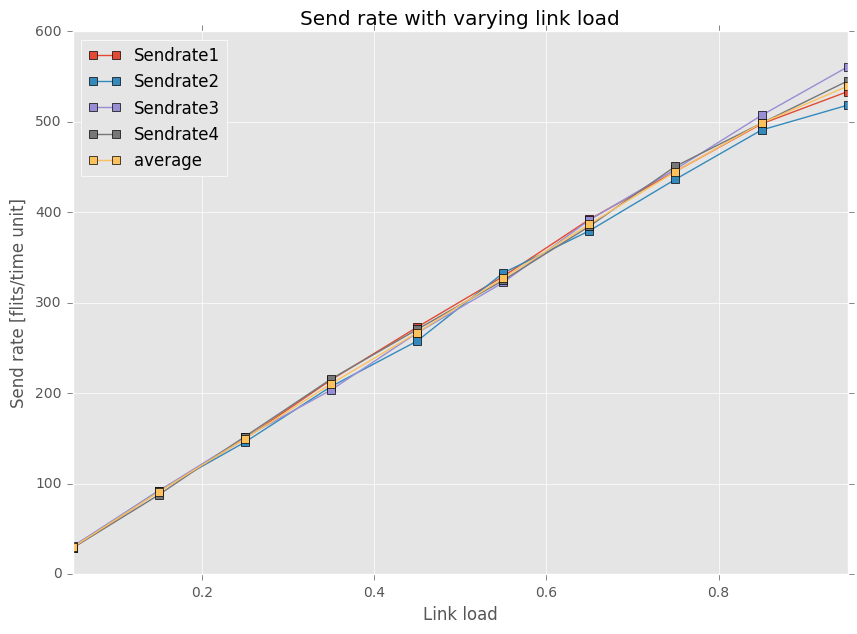

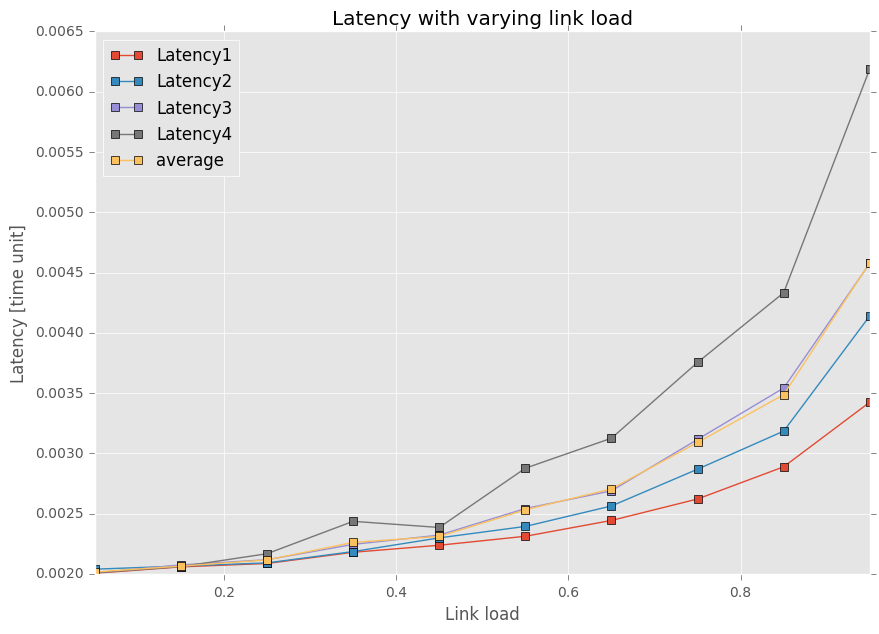

In [52]:
# plot line graphs for each buffer experiment with different load values
line_plot(sendrate_df, "Send rate with varying link load".format(load_value), 'Link load', 'Send rate [flits/time unit]', pdf)
plt.show()
line_plot(latency_df, "Latency with varying link load".format(load_value), 'Link load', 'Latency [time unit]', pdf)
plt.show()

# Plot a subset of the results
You can easily filter out some of the columns, like shown below

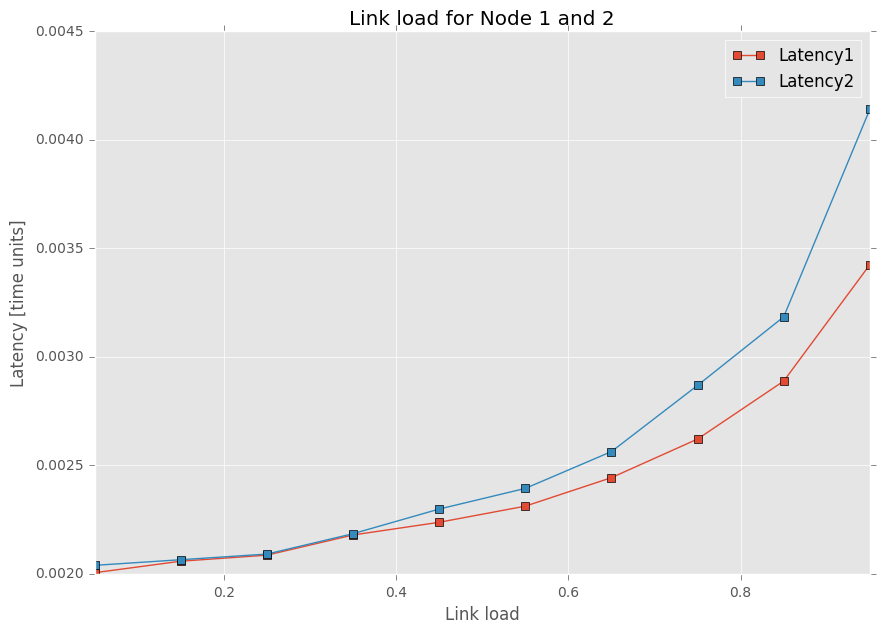

In [53]:
# extract only the rows for which the index correspondes to the first buffer value
latency12_df = latency_df[['Latency1', 'Latency2']] # select only the Latency1 and Latency2 columns
line_plot(latency12_df, "Link load for Node 1 and 2", 'Link load', 'Latency [time units]', pdf)
plt.show()

## Save results for future reference

In [54]:
latency_df.to_csv('Latency.txt') # load back into dataframe by using: df = pandas.from_csv('Latency.txt')
sendrate_df.to_csv('Sendrate.txt')

if pdf != None:
    pdf.close()
pdf = None # remove the reference to the multipage PDF